In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

nielsen = pd.concat((nielsen15, nielsen16))

In [3]:
density_path = "../data_collection/plein_de_data/Average_Household_Size_and_Population_Density_-_County.csv"
density = pd.read_csv(density_path)

In [4]:
density = density[["GEOID", "B01001_calc_PopDensity"]]

In [5]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'FRESH PRODUCE']
#print(milk.shape[0])

In [6]:
milk_d = pd.merge(milk, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')
#print(milk_d.shape[0])
#milk_d.head()

In [7]:
## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stil remain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
#movements['year'] = movements.Opening_date.dt.year
#movements['month'] = movements.Opening_date.dt.month

In [8]:
# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk_d[~np.isin(milk_d.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = milk_d[np.isin(milk_d.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
treatment['treat'] = True
treatment['interaction'] = (treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year >= treatment.Opening_date.dt.year)
treatment.describe()

Size of the control group: 2334.
Size of the treatment group: 89.


,guessed_store_county_fips,purchase_year,purchase_month,upc_price,upc_price_std,nb_of_obs,year,GEOID,B01001_calc_PopDensity,County_fips
count,4003.000000,4003.000000,4003.000000,4003.000000,3972.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000
mean,29679.224332,2015.503372,6.499625,2.149174,1.401495,264.726705,2015.503372,29679.224332,269.987630,29679.224332
std,16580.775093,0.500051,3.450396,0.374020,0.365643,559.317183,0.500051,16580.775093,528.998491,16580.775093
min,1043.000000,2015.000000,1.000000,0.630000,0.000000,1.000000,2015.000000,1043.000000,3.691471,1043.000000
25%,12103.000000,2015.000000,4.000000,1.925164,1.233649,35.000000,2015.000000,12103.000000,45.963848,12103.000000
50%,34029.000000,2016.000000,7.000000,2.130204,1.382387,89.000000,2016.000000,34029.000000,116.010549,34029.000000
75%,45045.000000,2016.000000,9.000000,2.346615,1.546400,252.000000,2016.000000,45045.000000,299.588930,45045.000000
max,56021.000000,2016.000000,12.000000,5.970000,6.442909,6596.000000,2016.000000,56021.000000,4322.952569,56021.000000


In [9]:
treatment_d = treatment[["GEOID","B01001_calc_PopDensity"]]
density_per_county_t = treatment_d.groupby("GEOID").agg(["mean"])
density_per_county_t.describe()

,B01001_calc_PopDensity
,mean
count,89.000000
mean,265.114160
std,523.002419
min,3.691471
25%,42.854831
50%,107.326459
75%,288.317756
max,4322.952569


In [10]:
#criterium for control group : values in same range as for treatment
min_d = density_per_county_t.min()[('B01001_calc_PopDensity','mean')]
max_d = density_per_county_t.max()[('B01001_calc_PopDensity','mean')]
print(min_d, max_d)
print(control.shape[0])
control_m = control[(control['B01001_calc_PopDensity']>=min_d)&(control['B01001_calc_PopDensity']<=max_d)]
print(control_m.shape[0], control_m.shape[0]/control.shape[0])

3.69147125917798 4322.95256868476
79763
74840 0.938279653473415


In [11]:
first_quartile = density_per_county_t.quantile(q=0.25)[('B01001_calc_PopDensity','mean')]
third_quartile = density_per_county_t.quantile(q=0.75)[('B01001_calc_PopDensity','mean')]
control_m2 = control[(control['B01001_calc_PopDensity']>=first_quartile)&(control['B01001_calc_PopDensity']<=third_quartile)]
print(control_m2.shape[0], control_m2.shape[0]/control.shape[0])

23296 0.2920652432832266


In [12]:
control_m = control_m[["is_walmart","store_state","guessed_store_county","guessed_store_county_fips","purchase_year","purchase_month","product_group_descr","upc_price","upc_price_std","nb_of_obs","year","treat","interaction",'B01001_calc_PopDensity']]

In [13]:
control_m2 = control_m2[["is_walmart","store_state","guessed_store_county","guessed_store_county_fips","purchase_year","purchase_month","product_group_descr","upc_price","upc_price_std","nb_of_obs","year","treat","interaction",'B01001_calc_PopDensity']]

AttributeError: 'Rectangle' object has no property 'column'

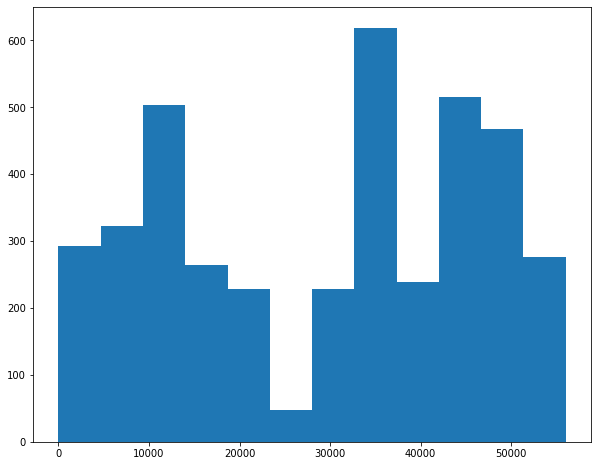

In [14]:
ax = treatment_d.plot.hist(column=['B01001_calc_PopDensity'], bins=12, figsize=(10, 8))

AttributeError: 'Rectangle' object has no property 'column'

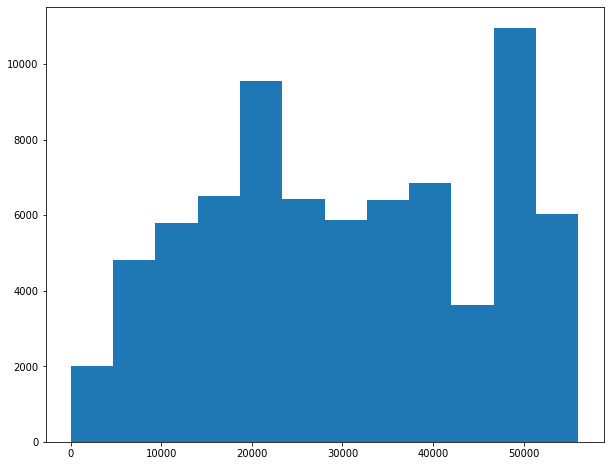

In [15]:
ax2 = control_m.plot.hist(column=['B01001_calc_PopDensity'], bins=12, figsize=(10, 8))

AttributeError: 'Rectangle' object has no property 'column'

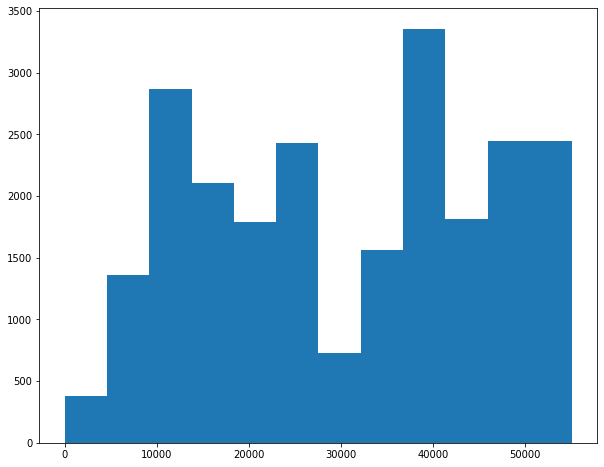

In [16]:
ax3 = control_m2.plot.hist(column=['B01001_calc_PopDensity'], bins=12, figsize=(10, 8))

(array([3336.,  451.,   72.,   96.,    0.,    0.,    0.,    0.,    0.,
          48.]),
 array([   0.,  435.,  870., 1305., 1740., 2175., 2610., 3045., 3480.,
        3915., 4350.]),
 <BarContainer object of 10 artists>)

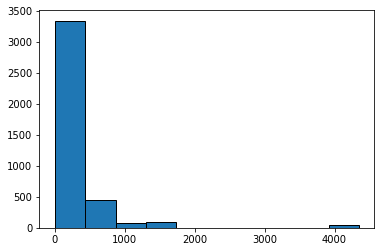

In [17]:
plt.hist(treatment_d['B01001_calc_PopDensity'], edgecolor='black', range=[0, 4350])

(array([7.1087e+04, 2.4100e+03, 9.0900e+02, 1.2000e+02, 1.9100e+02,
        3.5000e+01, 1.6000e+01, 4.8000e+01, 0.0000e+00, 2.4000e+01]),
 array([   0.,  435.,  870., 1305., 1740., 2175., 2610., 3045., 3480.,
        3915., 4350.]),
 <BarContainer object of 10 artists>)

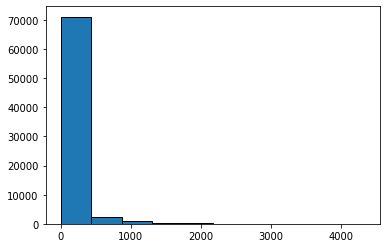

In [18]:
plt.hist(control_m['B01001_calc_PopDensity'], edgecolor='black', range=[0, 4350])

(array([23296.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([   0.,  435.,  870., 1305., 1740., 2175., 2610., 3045., 3480.,
        3915., 4350.]),
 <BarContainer object of 10 artists>)

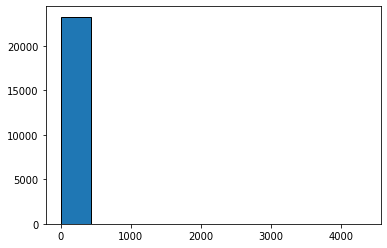

In [19]:
plt.hist(control_m2['B01001_calc_PopDensity'], edgecolor='black', range=[0, 4350])